In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# ============================================================
# ✅ FIX PATH FOR NOTEBOOK INSIDE /notebooks
# ============================================================
import sys, os
from pathlib import Path

# Xác định thư mục cha của notebooks/
project_root = Path(os.getcwd()).parent  # => C:\Users\User\RR_model
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))  # ⚠️ thêm project_root, KHÔNG thêm src

print("📁 Project root added:", project_root)

# Kiểm tra lại
import importlib.util
print("🔍 src module found:", importlib.util.find_spec("src"))

📁 Project root added: C:\Users\MAFC4709\Python_work\RR_model_1911_Projection
🔍 src module found: ModuleSpec(name='src', loader=<_frozen_importlib_external.SourceFileLoader object at 0x00000293528E6C20>, origin='C:\\Users\\MAFC4709\\Python_work\\RR_model_1911_Projection\\src\\__init__.py', submodule_search_locations=['C:\\Users\\MAFC4709\\Python_work\\RR_model_1911_Projection\\src'])


In [3]:
# ===========================================================
# 📘 Roll Rate Demo v7 - Sử dụng dữ liệu thật từ Oracle hoặc SQL file
# ===========================================================

from pathlib import Path
import sys
import pandas as pd
import numpy as np

# --- 1️⃣ Setup đường dẫn và import các module ---
root = Path(".").resolve()
sys.path.append(str(root / "src"))

from src.data_loader import load_data
from src.config import CFG, OUT_ROOT
from src.rollrate.transition import compute_transition_from_pairs, compute_transition_by_mob

from src.rollrate.export_excel import export_transition_excel
try:
    from src.rollrate.backtest import (
        compute_actual_matrix,
        rollforward_validation,
        plot_matrix_diff,
        plot_distribution_compare
    )
except Exception as e:
    print("Backtest modules not loaded:", e)

print("✅ Import modules thành công.")
print("Cấu hình CFG:", CFG)


# --- 2️⃣ Load dữ liệu thực tế ---
#sql_path = r"C:/Users/MAFC4709/Python_work/RR_model_1911/sql/uns2.sql"

#df = load_data(sql_path)
#df = load_data('C:/Users/MAFC4709/Python_work/POS_Parquet_2/')
df = load_data('C:/Users/MAFC4709/Python_work/ETB_Parquet_2')
#df = load_data('C:/Users/MAFC4709/Python_work/CASHLOAN_Parquet_2/')


df['DISBURSAL_DATE'] = df['DISBURSAL_DATE'].apply(lambda x: x.replace(day=1))

#print(f"📦 Đã load {len(df):,} dòng dữ liệu từ {sql_path}")

# Kiểm tra các cột quan trọng
required_cols = [CFG["loan"], CFG["mob"], CFG["state"], CFG["ead"], CFG["cutoff"]]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ Thiếu các cột cần thiết trong data: {missing}")

print("✅ Dữ liệu có đủ các cột cần thiết:", required_cols)

# Nếu chưa có PRODUCT_TYPE thì thêm mặc định
if "PRODUCT_TYPE" not in df.columns:
    df["PRODUCT_TYPE"] = "A"
    print("⚠️ Không có PRODUCT_TYPE trong data, gán mặc định = 'A'")

# Convert cutoff về datetime
df[CFG["cutoff"]] = pd.to_datetime(df[CFG["cutoff"]])





✅ Import modules thành công.
Cấu hình CFG: {'loan': 'AGREEMENT_ID', 'mob': 'MOB', 'state': 'STATE_MODEL', 'orig_date': 'DISBURSAL_DATE', 'ead': 'PRINCIPLE_OUTSTANDING', 'disb': 'DISBURSAL_AMOUNT', 'cutoff': 'CUTOFF_DATE', 'ROLL_WINDOW': 20, 'DECAY_LAMBDA': 0.9659363289248456}
📦 Loading Parquet from: C:\Users\MAFC4709\Python_work\ETB_Parquet_2
✅ Loaded 6,065,817 rows via pyarrow.dataset from C:\Users\MAFC4709\Python_work\ETB_Parquet_2
✅ Dữ liệu có đủ các cột cần thiết: ['AGREEMENT_ID', 'MOB', 'STATE_MODEL', 'PRINCIPLE_OUTSTANDING', 'CUTOFF_DATE']


# 0. Import & config chung

In [4]:
import pandas as pd
import numpy as np

from src.config import (
    CFG,
    BUCKETS_CANON,
    BUCKETS_30P,
    BUCKETS_60P,
    BUCKETS_90P,
)

from src.rollrate.transition import compute_transition_by_mob
from src.rollrate.lifecycle import (
    get_actual_all_vintages_amount,
    combine_all_lifecycle_amount,
    lifecycle_to_long_df_amount,
    tag_forecast_rows_amount,
    add_del_metrics,
    aggregate_to_product,
    aggregate_products_to_portfolio,
    export_lifecycle_all_products_one_file,
    extend_actual_info_with_portfolio,
)

from src.rollrate.calibration_kmob import (
    fit_k_raw,
    smooth_k,
    fit_alpha,
    forecast_all_vintages_partial_step,
    plot_k_curves,
    backtest_error_by_mob,
)


# 1. Đọc data loan-level & chuẩn hoá

In [5]:
#df_raw = df[df["PRODUCT_TYPE"] == "CDLPIL"].copy()
df_raw = df

In [6]:
# 1.1. Load data loan level


# 1.2. (Tuỳ) Chuẩn hoá tên cột, kiểu dữ liệu nếu cần
df_raw["PRODUCT_TYPE"] = df_raw["PRODUCT_TYPE"].astype(str)
df_raw["RISK_SCORE"]   = df_raw["RISK_SCORE"].astype(str)
df_raw[CFG["orig_date"]] = pd.to_datetime(df_raw[CFG["orig_date"]])


# 2. Build transition matrices theo MOB

In [7]:
matrices_by_mob, parent_fallback = compute_transition_by_mob(df_raw)

# (Tuỳ) validate matrices:
# from src.rollrate.forecast import validate_matrices
# validate_matrices(matrices_by_mob)


⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=TOPUP, score=A)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=TOPUP, score=B)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=TOPUP, score=C)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=TOPUP, score=D)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=TOPUP, score=NA)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=XSELL, score=A)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Built parent fallback for (product=XSELL, score=B)
⚠️ Có 4 hàng có tổng weight = 0: ['DPD120+', 'DPD180+', 'PREPAY', 'SOLDOUT']
⚙️ Bu

# 3. Lifecycle cho các khoản đã giải ngân (actual + forecast “gốc”)

In [8]:
max_mob = 36  # hoac 48, 60 tuy y

states = BUCKETS_CANON
s30_states = BUCKETS_30P

# Actual lifecycle by state (history)
actual_results = get_actual_all_vintages_amount(df_raw)

# Fit window: all vintages (set months to restrict)
FIT_MONTHS = None  # e.g., 6 or 12 to restrict
if FIT_MONTHS is None:
    df_fit = df_raw
else:
    fit_start = df_raw[CFG["orig_date"]].max() - pd.DateOffset(months=FIT_MONTHS)
    df_fit = df_raw[df_raw[CFG["orig_date"]] >= fit_start].copy()

actual_results_fit = get_actual_all_vintages_amount(df_fit)

# DISB_TOTAL map for fit window (cohort-based)
loan_disb_fit = (
    df_fit.groupby(["PRODUCT_TYPE", "RISK_SCORE", CFG["orig_date"], CFG["loan"]])[CFG["disb"]]
    .first()
)
cohort_disb_fit = loan_disb_fit.groupby(level=[0, 1, 2]).sum()
disb_total_by_vintage_fit = cohort_disb_fit.to_dict()


# 4. Fit k theo one-step DEL30 (partial-step overlay)

In [9]:
k_raw_by_mob, weight_by_mob, k_raw_df = fit_k_raw(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
    method="wls",
    eps=1e-8,
    min_denom=1e-10,
    min_obs=5,
    fallback_k=1.0,
    fallback_weight=0.0,
    return_detail=True,
)

print("k_raw_by_mob:", k_raw_by_mob)

if not k_raw_df.empty:
    def _wls_summary(g):
        denom = np.sum(g["weight"] * (g["a"] ** 2))
        numer = np.sum(g["weight"] * g["a"] * g["d"])
        k_wls = k_raw_by_mob.get(int(g.name), np.nan)
        return pd.Series({
            "n_obs": int(g.shape[0]),
            "w_sum": g["weight"].sum(),
            "denom_wls": denom,
            "numer_wls": numer,
            "k_wls": k_wls,
        })

    k_raw_summary = k_raw_df.groupby("mob").apply(_wls_summary).reset_index()
    k_raw_summary

if k_raw_by_mob:
    mob_min = min(k_raw_by_mob.keys())
    mob_max = max(k_raw_by_mob.keys())
else:
    mob_min, mob_max = 0, 0

k_smooth_by_mob, mobs, _ = smooth_k(
    k_raw_by_mob=k_raw_by_mob,
    weight_by_mob=weight_by_mob,
    mob_min=mob_min,
    mob_max=mob_max,
    gamma=10.0,
    monotone=False,
    use_cvxpy=True,
    default_k=1.0,
)

ALPHA_TARGET_MOB = min(max_mob, mob_max) if mob_max else max_mob
alpha, k_final_by_mob, alpha_scores = fit_alpha(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_smooth_by_mob=k_smooth_by_mob,
    mob_target=ALPHA_TARGET_MOB,
    include_co=True,
    alpha_grid=None,
    val_frac=0.2,
)

print("alpha:", alpha)
print("k_final_by_mob:", k_final_by_mob)


k_raw_by_mob: {0: 0.9243902921907773, 1: 1.0, 2: 1.0, 3: 1.0, 4: 0.903424608228122, 5: 0.9526087285775936, 6: 0.9168805352068564, 7: 0.523898737840431, 8: 0.41795332688945286, 9: 0.3375902982937189, 10: 1.0, 11: 1.0, 12: 1.0, 13: 0.8616051055075461, 14: 0.036313264293202675, 15: 1.0, 16: 0.7625139531794196, 17: 0.8653174742385535, 18: 0.8491932393447712, 19: 0.7644827985269482, 20: 0.694592698849451, 21: 1.0, 22: 1.0, 23: 0.3043484115566687}
alpha: 1.0
k_final_by_mob: {0: 0.926884712336757, 1: 0.9954932979545862, 2: 1.0, 3: 0.9912438240653858, 4: 0.9181411754297778, 5: 0.9520378417995524, 6: 0.8905102954091639, 7: 0.5456322371042867, 8: 0.3992624293757033, 9: 0.39856454293781574, 10: 0.935595258468685, 11: 1.0, 12: 0.998258108292458, 13: 0.7769943661126117, 14: 0.21812682027450386, 15: 0.8535051908053136, 16: 0.8150437362762026, 17: 0.8569144536670221, 18: 0.8403299310371659, 19: 0.7609307336222904, 20: 0.7473312062583994, 21: 0.9785532222126202, 22: 0.932230573516605, 23: 0.3540546613

C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19672\3181303332.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  k_raw_summary = k_raw_df.groupby("mob").apply(_wls_summary).reset_index()


In [10]:
# WLS with regularization (k_prior=0 to bias k downward)
LAMBDA_K = 1e-4
K_PRIOR = 0.0

k_raw_reg_by_mob, weight_reg_by_mob, k_raw_reg_df = fit_k_raw(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
    method="wls_reg",
    lambda_k=LAMBDA_K,
    k_prior=K_PRIOR,
    eps=1e-8,
    min_denom=1e-10,
    min_obs=5,
    fallback_k=1.0,
    fallback_weight=0.0,
    return_detail=True,
)

print('k_raw_reg_by_mob:', k_raw_reg_by_mob)

mobs = sorted(set(k_raw_by_mob) | set(k_raw_reg_by_mob))
df_k_compare = pd.DataFrame({
    'mob': mobs,
    'k_wls': [k_raw_by_mob.get(m, np.nan) for m in mobs],
    'k_wls_reg': [k_raw_reg_by_mob.get(m, np.nan) for m in mobs],
})
df_k_compare['delta'] = df_k_compare['k_wls_reg'] - df_k_compare['k_wls']
display(df_k_compare)


k_raw_reg_by_mob: {0: 0.7957549282432411, 1: 1.0, 2: 1.0, 3: 1.0, 4: 0.9025393730650164, 5: 0.9515096549325318, 6: 0.9158315752447839, 7: 0.523778815679516, 8: 0.41784864632498975, 9: 0.33728460823179146, 10: 1.0, 11: 1.0, 12: 1.0, 13: 0.8568368799130972, 14: 0.03630363482514366, 15: 1.0, 16: 0.7577446148523209, 17: 0.8586875264394577, 18: 0.8404577665031945, 19: 0.7504709390790705, 20: 0.6761243385776274, 21: 1.0, 22: 1.0, 23: 0.2965627603352914}


,mob,k_wls,k_wls_reg,delta
0,0,0.924390,0.795755,-0.128635
1,1,1.000000,1.000000,0.000000
2,2,1.000000,1.000000,0.000000
3,3,1.000000,1.000000,0.000000
4,4,0.903425,0.902539,-0.000885
5,5,0.952609,0.951510,-0.001099
6,6,0.916881,0.915832,-0.001049
7,7,0.523899,0.523779,-0.000120
8,8,0.417953,0.417849,-0.000105
9,9,0.337590,0.337285,-0.000306


In [11]:
# Smooth + alpha for regularized k
if k_raw_reg_by_mob:
    mob_min_reg = min(k_raw_reg_by_mob.keys())
    mob_max_reg = max(k_raw_reg_by_mob.keys())
else:
    mob_min_reg, mob_max_reg = 0, 0

k_smooth_reg_by_mob, mobs_reg, _ = smooth_k(
    k_raw_by_mob=k_raw_reg_by_mob,
    weight_by_mob=weight_reg_by_mob,
    mob_min=mob_min_reg,
    mob_max=mob_max_reg,
    gamma=10.0,
    monotone=False,
    use_cvxpy=True,
    default_k=1.0,
)

ALPHA_TARGET_MOB_REG = min(max_mob, mob_max_reg) if mob_max_reg else max_mob
alpha_reg, k_final_reg_by_mob, alpha_scores_reg = fit_alpha(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_smooth_by_mob=k_smooth_reg_by_mob,
    mob_target=ALPHA_TARGET_MOB_REG,
    include_co=True,
    alpha_grid=None,
    val_frac=0.2,
)

print('alpha_reg:', alpha_reg)
print('k_final_reg_by_mob:', k_final_reg_by_mob)


alpha_reg: 1.0
k_final_reg_by_mob: {0: 0.80245495699156, 1: 0.9873275590486617, 2: 1.0, 3: 0.9914362228593303, 4: 0.9173380636255556, 5: 0.9509204406139636, 6: 0.8895246738138165, 7: 0.5454394590731514, 8: 0.3991498121497394, 9: 0.3983126881990009, 10: 0.9355853050526473, 11: 1.0, 12: 0.9977026018720483, 13: 0.7731994153386113, 14: 0.2176438067672313, 15: 0.8531369307945699, 16: 0.8107237853993134, 17: 0.8502884580806364, 18: 0.8310457430525788, 19: 0.7465815961908303, 20: 0.7316496796764753, 21: 0.9762201150056958, 22: 0.9317692352950614, 23: 0.3470550676308801}


In [12]:
# Debug WLS details per MOB (numerator/denominator, fallback, clipping)
MIN_OBS = 5
MIN_DENOM = 1e-10
EPS = 1e-8

df = k_raw_df.copy()
if df.empty:
    print("k_raw_df empty -> no data to fit.")
else:
    required = {"mob", "weight", "a", "d"}
    missing = required - set(df.columns)
    if missing:
        print("Missing columns:", missing)
    
    df["w_a2"] = df["weight"] * (df["a"] ** 2)
    df["w_ad"] = df["weight"] * df["a"] * df["d"]
    df["k_ratio"] = np.where(df["a"].abs() < EPS, np.nan, df["d"] / df["a"])

    def _agg(g):
        denom = g["w_a2"].sum()
        numer = g["w_ad"].sum()
        k_raw = numer / denom if denom != 0 else np.nan
        return pd.Series({
            "n_obs": int(g.shape[0]),
            "w_sum": g["weight"].sum(),
            "denom_wls": denom,
            "numer_wls": numer,
            "k_wls_raw": k_raw,
            "k_wls_clipped": np.clip(k_raw, 0, 1) if np.isfinite(k_raw) else np.nan,
            "pct_a_small": (g["a"].abs() < EPS).mean(),
            "pct_k_ratio_gt1": (g["k_ratio"] > 1).mean(),
            "pct_k_ratio_lt0": (g["k_ratio"] < 0).mean(),
            "a_min": g["a"].min(),
            "a_max": g["a"].max(),
            "d_min": g["d"].min(),
            "d_max": g["d"].max(),
        })

    summary = df.groupby("mob").apply(_agg).reset_index()
    summary["wls_used"] = (summary["n_obs"] >= MIN_OBS) & (summary["denom_wls"] >= MIN_DENOM)
    summary["k_from_func"] = summary["mob"].map(k_raw_by_mob)
    summary["is_fallback"] = ~summary["wls_used"]

    display(summary.sort_values("mob"))

    # Inspect a MOB where k is 1 or fallback, if available
    pick = summary[summary["k_from_func"] >= 0.999]
    if pick.empty:
        pick = summary[summary["is_fallback"]]
    if pick.empty:
        mob_to_inspect = summary["mob"].iloc[0]
    else:
        mob_to_inspect = pick["mob"].iloc[0]

    detail = df[df["mob"] == mob_to_inspect].copy()
    detail = detail.sort_values("weight", ascending=False)
    display(detail[["mob", "weight", "a", "d", "k_ratio", "w_a2", "w_ad"]].head(50))


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19672\1446538653.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby("mob").apply(_agg).reset_index()


,mob,n_obs,w_sum,denom_wls,numer_wls,k_wls_raw,k_wls_clipped,pct_a_small,pct_k_ratio_gt1,pct_k_ratio_lt0,a_min,a_max,d_min,d_max,wls_used,k_from_func,is_fallback
0,0,257.0,257.0,0.000619,0.000572,0.924390,0.924390,0.431907,0.284047,0.000000,0.000000,0.007784,0.000000,0.008078,True,0.924390,False
1,1,255.0,255.0,0.092890,0.093243,1.003792,1.000000,0.113725,0.447059,0.000000,0.000000,0.117640,0.000000,0.157801,True,1.000000,False
2,2,255.0,255.0,0.156470,0.193873,1.239037,1.000000,0.086275,0.443137,0.007843,-0.009716,0.217918,-0.008263,0.410214,True,1.000000,False
3,3,254.0,254.0,0.652142,0.763000,1.169990,1.000000,0.074803,0.409449,0.003937,-0.010452,0.695980,0.000000,0.933586,True,1.000000,False
4,4,254.0,254.0,0.101955,0.092108,0.903425,0.903425,0.082677,0.440945,0.015748,-0.057481,0.053393,-0.002375,0.045313,True,0.903425,False
5,5,254.0,254.0,0.086574,0.082471,0.952609,0.952609,0.082677,0.452756,0.015748,-0.025651,0.047566,-0.004704,0.046080,True,0.952609,False
6,6,254.0,254.0,0.087309,0.080051,0.916881,0.916881,0.082677,0.370079,0.007874,-0.000682,0.047647,-0.005349,0.045689,True,0.916881,False
7,7,246.0,246.0,0.436766,0.228821,0.523899,0.523899,0.073171,0.430894,0.028455,-0.000798,0.531231,-0.002695,0.567310,True,0.523899,False
8,8,238.0,238.0,0.399165,0.166833,0.417953,0.417953,0.071429,0.436975,0.029412,-0.068407,0.531231,-0.004350,0.476190,True,0.417953,False
9,9,230.0,230.0,0.110335,0.037248,0.337590,0.337590,0.073913,0.443478,0.030435,-0.011320,0.265615,-0.007699,0.035907,True,0.337590,False


,mob,weight,a,d,k_ratio,w_a2,w_ad
100,1,1.0,0.005192,0.006067,1.168665,2.695404e-05,3.150025e-05
124,1,1.0,0.000585,0.000923,1.576814,3.425784e-07,5.401823e-07
148,1,1.0,0.004289,0.002310,0.538625,1.839207e-05,9.906424e-06
172,1,1.0,0.001311,0.002068,1.576814,1.719808e-06,2.711816e-06
196,1,1.0,0.005192,0.003109,0.598849,2.695252e-05,1.614048e-05
220,1,1.0,0.003161,0.004984,1.576814,9.990587e-06,1.575329e-05
244,1,1.0,0.000473,0.000746,1.576814,2.240110e-07,3.532237e-07
268,1,1.0,0.003469,0.005469,1.576814,1.203072e-05,1.897020e-05
291,1,1.0,0.006042,0.005955,0.985509,3.650839e-05,3.597933e-05
313,1,1.0,0.004269,0.002301,0.538881,1.822855e-05,9.823025e-06


In [13]:
# Comparison table: Markov vs Actual DEL30 per MOB (weighted)
df = k_raw_df.copy()
req_cols = {"mob", "weight", "y_vm", "y_hat", "y_tar", "a", "d"}
if df.empty:
    print("k_raw_df empty -> no data to compare.")
elif not req_cols.issubset(df.columns):
    print("Missing columns:", req_cols - set(df.columns))
else:
    df["k_ratio"] = np.where(df["a"].abs() < EPS, np.nan, df["d"] / df["a"])

    def _wavg(s, w):
        total = w.sum()
        return float(np.average(s, weights=w)) if total > 0 else np.nan

    def _agg(g):
        w = g["weight"]
        y_vm = _wavg(g["y_vm"], w)
        y_hat = _wavg(g["y_hat"], w)
        y_tar = _wavg(g["y_tar"], w)
        denom = float(np.sum(w * (g["a"] ** 2)))
        numer = float(np.sum(w * g["a"] * g["d"]))
        return pd.Series({
            "n_obs": int(g.shape[0]),
            "w_sum": float(w.sum()),
            "y_vm_wavg": y_vm,
            "y_hat_wavg": y_hat,
            "y_tar_wavg": y_tar,
            "a_wavg": _wavg(g["a"], w),
            "d_wavg": _wavg(g["d"], w),
            "gap_hat_minus_tar": y_hat - y_tar if np.isfinite(y_hat) and np.isfinite(y_tar) else np.nan,
            "k_wls_raw": numer / denom if denom != 0 else np.nan,
            "k_ratio_wavg": _wavg(g["k_ratio"], w),
        })

    compare_by_mob = df.groupby("mob").apply(_agg).reset_index()
    display(compare_by_mob.sort_values("mob"))


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19672\3471683643.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  compare_by_mob = df.groupby("mob").apply(_agg).reset_index()


,mob,n_obs,w_sum,y_vm_wavg,y_hat_wavg,y_tar_wavg,a_wavg,d_wavg,gap_hat_minus_tar,k_wls_raw,k_ratio_wavg
0,0,257.0,257.0,0.000000,0.000785,0.000772,0.000785,0.000772,0.000013,0.924390,NaN
1,1,255.0,255.0,0.000815,0.014384,0.013985,0.013568,0.013170,0.000398,1.003792,NaN
2,2,255.0,255.0,0.014183,0.031141,0.031292,0.016958,0.017109,-0.000151,1.239037,NaN
3,3,254.0,254.0,0.032122,0.053316,0.052595,0.021193,0.020472,0.000721,1.169990,NaN
4,4,254.0,254.0,0.056793,0.073103,0.072578,0.016310,0.015785,0.000525,0.903425,NaN
5,5,254.0,254.0,0.072209,0.087325,0.087033,0.015116,0.014825,0.000292,0.952609,NaN
6,6,254.0,254.0,0.088400,0.104054,0.102884,0.015654,0.014484,0.001170,0.916881,NaN
7,7,246.0,246.0,0.102899,0.119917,0.117880,0.017018,0.014981,0.002037,0.523899,NaN
8,8,238.0,238.0,0.117847,0.132979,0.131493,0.015131,0.013646,0.001486,0.417953,NaN
9,9,230.0,230.0,0.131582,0.143820,0.142254,0.012239,0.010672,0.001566,0.337590,NaN


In [14]:
# Detailed WLS breakdown for selected MOBs
MOBS_FOCUS = [10, 11, 12, 13]  # set None for all
EPS = 1e-8

df = k_raw_df.copy()
if df.empty:
    print("k_raw_df empty -> no data.")
else:
    focus = df if MOBS_FOCUS is None else df[df["mob"].isin(MOBS_FOCUS)]
    if focus.empty:
        print("No rows for MOBS_FOCUS:", MOBS_FOCUS)
    else:
        def _wavg(x, w):
            total = w.sum()
            return float(np.average(x, weights=w)) if total > 0 else np.nan

        def _mob_diag(g):
            w = g["weight"].values
            a = g["a"].values
            d = g["d"].values
            denom = float(np.sum(w * a * a))
            numer = float(np.sum(w * a * d))
            k_raw = numer / denom if denom != 0 else np.nan
            return pd.Series({
                "n_obs": int(len(g)),
                "w_sum": float(w.sum()),
                "denom_wls": denom,
                "numer_wls": numer,
                "k_wls_raw": k_raw,
                "k_wls_clipped": np.clip(k_raw, 0, 1) if np.isfinite(k_raw) else np.nan,
                "a_wavg": _wavg(a, w),
                "d_wavg": _wavg(d, w),
                "pct_a_neg": float(np.mean(a < 0)),
                "pct_d_neg": float(np.mean(d < 0)),
                "pct_sign_mismatch": float(np.mean(np.sign(a) != np.sign(d))),
                "pct_a_small": float(np.mean(np.abs(a) < EPS)),
            })

        mob_detail = focus.groupby("mob").apply(_mob_diag).reset_index()
        mob_detail["k_from_func"] = mob_detail["mob"].map(k_raw_by_mob)
        display(mob_detail.sort_values("mob"))

        seg_cols = {"product", "score"}
        if seg_cols.issubset(focus.columns):
            seg = focus.copy()
            seg["segment"] = seg["product"].astype(str) + "|" + seg["score"].astype(str)

            def _seg_diag(g):
                w = g["weight"].values
                a = g["a"].values
                d = g["d"].values
                denom = float(np.sum(w * a * a))
                numer = float(np.sum(w * a * d))
                k_raw = numer / denom if denom != 0 else np.nan
                return pd.Series({
                    "n_obs": int(len(g)),
                    "w_sum": float(w.sum()),
                    "denom_wls": denom,
                    "numer_wls": numer,
                    "k_wls_raw": k_raw,
                    "a_wavg": _wavg(a, w),
                    "d_wavg": _wavg(d, w),
                })

            seg_detail = seg.groupby(["mob", "segment"]).apply(_seg_diag).reset_index()
            for mob in sorted(seg_detail["mob"].unique()):
                top = seg_detail[seg_detail["mob"] == mob].copy()
                top["abs_numer"] = top["numer_wls"].abs()
                top = top.sort_values("abs_numer", ascending=False).head(10)
                print(f"\nTop segments by |numer| for MOB {mob}")
                display(top[["segment", "n_obs", "w_sum", "numer_wls", "denom_wls", "k_wls_raw", "a_wavg", "d_wavg"]])
        else:
            print("Detail columns missing for segment breakdown (product/score).")


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19672\2899339469.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mob_detail = focus.groupby("mob").apply(_mob_diag).reset_index()


,mob,n_obs,w_sum,denom_wls,numer_wls,k_wls_raw,k_wls_clipped,a_wavg,d_wavg,pct_a_neg,pct_d_neg,pct_sign_mismatch,pct_a_small,k_from_func
0,10,220.0,220.0,0.047793,0.050248,1.051364,1.000000,0.011096,0.010689,0.004545,0.040909,0.050000,0.072727,1.000000
1,11,211.0,211.0,0.110319,0.135419,1.227522,1.000000,0.011830,0.011938,0.018957,0.047393,0.052133,0.061611,1.000000
2,12,203.0,203.0,0.101474,0.125319,1.234993,1.000000,0.009650,0.009522,0.029557,0.078818,0.073892,0.059113,1.000000
3,13,195.0,195.0,0.017970,0.015483,0.861605,0.861605,0.007679,0.006777,0.046154,0.087179,0.082051,0.066667,0.861605



Top segments by |numer| for MOB 10


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19672\2899339469.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg_detail = seg.groupby(["mob", "segment"]).apply(_seg_diag).reset_index()


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
9,XSELL|NA,10.0,10.0,0.019696,0.015239,1.292464,0.015041,0.017761
3,TOPUP|D,25.0,25.0,0.008878,0.008926,0.994524,0.018192,0.018660
2,TOPUP|C,25.0,25.0,0.007215,0.007144,1.009890,0.016514,0.016665
7,XSELL|C,25.0,25.0,0.003229,0.003675,0.878718,0.011244,0.010281
8,XSELL|D,25.0,25.0,0.003165,0.003951,0.800957,0.011744,0.009564
1,TOPUP|B,25.0,25.0,0.003128,0.003143,0.995152,0.010787,0.010678
0,TOPUP|A,25.0,25.0,0.001846,0.001948,0.947485,0.008101,0.007716
6,XSELL|B,25.0,25.0,0.001570,0.001712,0.917131,0.007473,0.007059
5,XSELL|A,25.0,25.0,0.001418,0.001738,0.815785,0.007354,0.006056
4,TOPUP|NA,10.0,10.0,0.000104,0.000317,0.329730,0.000554,0.000694



Top segments by |numer| for MOB 11


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
14,TOPUP|NA,10.0,10.0,0.110597,0.058775,1.881711,0.033938,0.063433
13,TOPUP|D,24.0,24.0,0.007307,0.007313,0.999168,0.016910,0.017715
12,TOPUP|C,24.0,24.0,0.005616,0.005779,0.971797,0.014866,0.014872
18,XSELL|D,24.0,24.0,0.003563,0.004277,0.832951,0.012707,0.010622
11,TOPUP|B,24.0,24.0,0.002936,0.003026,0.970234,0.010712,0.010351
10,TOPUP|A,24.0,24.0,0.001533,0.001532,1.000684,0.007400,0.007476
16,XSELL|B,24.0,24.0,0.001380,0.001507,0.915820,0.007019,0.006295
17,XSELL|C,24.0,24.0,0.001318,0.001593,0.827659,0.007407,0.006276
15,XSELL|A,24.0,24.0,0.001069,0.001465,0.729551,0.006052,0.004649
19,XSELL|NA,9.0,9.0,0.000100,0.025053,0.004010,0.018106,0.000714



Top segments by |numer| for MOB 12


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
29,XSELL|NA,9.0,9.0,0.106592,0.079004,1.349205,0.039790,0.035483
23,TOPUP|D,23.0,23.0,0.005613,0.005610,1.000567,0.015093,0.015757
22,TOPUP|C,23.0,23.0,0.004418,0.004444,0.994163,0.013600,0.013839
21,TOPUP|B,23.0,23.0,0.002244,0.002448,0.916415,0.009961,0.009368
27,XSELL|C,23.0,23.0,0.001620,0.001669,0.970403,0.007317,0.006649
26,XSELL|B,23.0,23.0,0.001396,0.001548,0.902248,0.007562,0.006644
25,XSELL|A,23.0,23.0,0.001228,0.001272,0.964862,0.005778,0.005922
20,TOPUP|A,23.0,23.0,0.001074,0.001060,1.013515,0.006067,0.006111
28,XSELL|D,23.0,23.0,0.001066,0.001327,0.803418,0.007126,0.005506
24,TOPUP|NA,10.0,10.0,0.000068,0.003091,0.021935,-0.006673,0.000825



Top segments by |numer| for MOB 13


,segment,n_obs,w_sum,numer_wls,denom_wls,k_wls_raw,a_wavg,d_wavg
33,TOPUP|D,22.0,22.0,0.004594,0.004965,0.925361,0.014234,0.013634
32,TOPUP|C,22.0,22.0,0.003310,0.003709,0.892557,0.012309,0.011334
31,TOPUP|B,22.0,22.0,0.001895,0.001983,0.955723,0.009119,0.008571
36,XSELL|B,22.0,22.0,0.001861,0.001965,0.946689,0.008809,0.007780
37,XSELL|C,22.0,22.0,0.001227,0.001493,0.821819,0.007437,0.005819
38,XSELL|D,22.0,22.0,0.000877,0.001290,0.679458,0.006650,0.004148
35,XSELL|A,22.0,22.0,0.000830,0.001032,0.803782,0.005368,0.004526
30,TOPUP|A,22.0,22.0,0.000663,0.000785,0.844054,0.005322,0.004918
34,TOPUP|NA,10.0,10.0,0.000214,0.000175,1.223271,-0.000280,-0.001677
39,XSELL|NA,9.0,9.0,0.000013,0.000572,0.022051,-0.002587,0.000239


In [15]:
# Step-by-step per vintage using forecast path (MOB 3-6)
VINTAGES_FOCUS = [ "2025-09", "2025-10", "2025-11", "2025-12"]
START_MOB = 3
END_MOB = 6
DENOM_MODE = "disb"  # use DISB_TOTAL denominator

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage_fit
except NameError:
    disb_map = {}

focus_periods = {pd.Period(v, freq="M") for v in VINTAGES_FOCUS}
state_set = set(states)
s30 = [s for s in s30_states if s in state_set]
s30_idx = np.array([states.index(s) for s in s30], dtype=int)

from src.rollrate.calibration_kmob import _get_P_for_segment, forecast_segment_partial_step

rows = []
debug = []
for (prod, score, vintage), mob_dict in actual_src.items():
    v_period = pd.to_datetime(vintage).to_period("M")
    if v_period not in focus_periods:
        continue
    max_actual_mob = max(mob_dict.keys()) if mob_dict else None
    has_start = START_MOB in mob_dict
    debug.append({"vintage_m": str(v_period), "product": prod, "score": score, "max_actual_mob": max_mob, "has_start_mob": has_start})
    if not has_start:
        continue

    key = (prod, score, vintage)
    disb_total = float(disb_map.get(key, 0.0))
    if DENOM_MODE == "disb" and disb_total <= 0:
        continue

    v_start = mob_dict[START_MOB].reindex(states, fill_value=0.0).astype(float)
    fc = forecast_segment_partial_step(
        matrices_by_mob=matrices_by_mob,
        parent_fallback=parent_fallback,
        product=prod,
        score=score,
        start_mob=START_MOB,
        initial_ead=v_start,
        max_mob=END_MOB,
        k_by_mob=k_final_by_mob,
        states=states,
    )

    for m in range(START_MOB, END_MOB):
        if m not in fc:
            continue
        v_m = fc[m].reindex(states, fill_value=0.0).astype(float)
        P_df = _get_P_for_segment(matrices_by_mob, parent_fallback, prod, score, m, states)
        v_hat = v_m.values @ P_df.values
        k_m = float(np.clip(k_final_by_mob.get(m, 1.0), 0.0, 1.0))
        v_adj_next = fc.get(m + 1, v_m + k_m * (pd.Series(v_hat, index=states) - v_m))

        if DENOM_MODE == "disb":
            y_vm = float(np.sum(v_m.values[s30_idx])) / disb_total
            y_hat = float(np.sum(v_hat[s30_idx])) / disb_total
            y_adj = float(np.sum(v_adj_next.values[s30_idx])) / disb_total
        else:
            y_vm = float(np.sum(v_m.values[s30_idx])) / float(v_m.values.sum())
            y_hat = float(np.sum(v_hat[s30_idx])) / float(v_hat.sum())
            y_adj = float(np.sum(v_adj_next.values[s30_idx])) / float(v_adj_next.values.sum())

        y_tar = np.nan
        if (m + 1) in mob_dict:
            v_m1 = mob_dict[m + 1].reindex(states, fill_value=0.0).astype(float)
            if DENOM_MODE == "disb":
                y_tar = float(np.sum(v_m1.values[s30_idx])) / disb_total
            else:
                y_tar = float(np.sum(v_m1.values[s30_idx])) / float(v_m1.values.sum())

        rows.append({
            "vintage_m": str(v_period),
            "product": prod,
            "score": score,
            "mob_from": m,
            "mob_to": m + 1,
            "k_m": k_m,
            "y_vm": y_vm,
            "y_hat": y_hat,
            "y_adj": y_adj,
            "y_tar": y_tar,
            "step_hat": y_hat - y_vm,
            "step_adj": y_adj - y_vm,
            "has_actual_to": int((m + 1) in mob_dict),
            "base_is_actual": int(m == START_MOB),
        })

df_step = pd.DataFrame(rows)
if df_step.empty:
    print("No rows for selected vintages or MOB range.")
    if debug:
        display(pd.DataFrame(debug).sort_values(["vintage_m", "product", "score"]))
    else:
        available_periods = sorted({pd.to_datetime(k[2]).to_period("M") for k in actual_src.keys()})
        print("Available vintages (last 12):", [str(p) for p in available_periods[-12:]])
else:
    df_step = df_step.sort_values(["vintage_m", "product", "score", "mob_from"])
    display(df_step)

    cols = ["vintage_m", "product", "score", "mob_from", "mob_to", "k_m", "step_hat", "step_adj", "y_vm", "y_adj", "y_tar", "has_actual_to"]
    display(df_step[cols])


,vintage_m,product,score,mob_from,mob_to,k_m,y_vm,y_hat,y_adj,y_tar,step_hat,step_adj,has_actual_to,base_is_actual
0,2025-09,TOPUP,A,3,4,0.991244,0.006525,0.009304,0.009280,NaN,0.002779,0.002754,0,1
1,2025-09,TOPUP,A,4,5,0.918141,0.009280,0.015862,0.015324,NaN,0.006583,0.006044,0,0
2,2025-09,TOPUP,A,5,6,0.952038,0.015324,0.023386,0.023000,NaN,0.008063,0.007676,0,0
3,2025-09,TOPUP,B,3,4,0.991244,0.023106,0.037904,0.037775,NaN,0.014798,0.014669,0,1
4,2025-09,TOPUP,B,4,5,0.918141,0.037775,0.052517,0.051310,NaN,0.014742,0.013536,0,0
5,2025-09,TOPUP,B,5,6,0.952038,0.051310,0.064436,0.063806,NaN,0.013125,0.012496,0,0
6,2025-09,TOPUP,C,3,4,0.991244,0.034405,0.054251,0.054078,NaN,0.019846,0.019673,0,1
7,2025-09,TOPUP,C,4,5,0.918141,0.054078,0.071678,0.070237,NaN,0.017600,0.016160,0,0
8,2025-09,TOPUP,C,5,6,0.952038,0.070237,0.086905,0.086105,NaN,0.016668,0.015868,0,0
9,2025-09,TOPUP,D,3,4,0.991244,0.074034,0.108731,0.108428,NaN,0.034698,0.034394,0,1


,vintage_m,product,score,mob_from,mob_to,k_m,step_hat,step_adj,y_vm,y_adj,y_tar,has_actual_to
0,2025-09,TOPUP,A,3,4,0.991244,0.002779,0.002754,0.006525,0.009280,NaN,0
1,2025-09,TOPUP,A,4,5,0.918141,0.006583,0.006044,0.009280,0.015324,NaN,0
2,2025-09,TOPUP,A,5,6,0.952038,0.008063,0.007676,0.015324,0.023000,NaN,0
3,2025-09,TOPUP,B,3,4,0.991244,0.014798,0.014669,0.023106,0.037775,NaN,0
4,2025-09,TOPUP,B,4,5,0.918141,0.014742,0.013536,0.037775,0.051310,NaN,0
5,2025-09,TOPUP,B,5,6,0.952038,0.013125,0.012496,0.051310,0.063806,NaN,0
6,2025-09,TOPUP,C,3,4,0.991244,0.019846,0.019673,0.034405,0.054078,NaN,0
7,2025-09,TOPUP,C,4,5,0.918141,0.017600,0.016160,0.054078,0.070237,NaN,0
8,2025-09,TOPUP,C,5,6,0.952038,0.016668,0.015868,0.070237,0.086105,NaN,0
9,2025-09,TOPUP,D,3,4,0.991244,0.034698,0.034394,0.074034,0.108428,NaN,0


In [16]:
# Diagnose DEL30 numerator/denominator at MOB=3 (cohort/product/score)
MOB_CHECK = 3
VINTAGE_CHECK = '2025-08'  # YYYY-MM

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage_fit
except NameError:
    disb_map = {}

v_target = pd.Period(VINTAGE_CHECK, freq='M')
state_set = set(states)
s30 = [s for s in s30_states if s in state_set]

rows = []
for (prod, score, vint), mob_dict in actual_src.items():
    if pd.to_datetime(vint).to_period('M') != v_target:
        continue
    if MOB_CHECK not in mob_dict:
        continue
    v = mob_dict[MOB_CHECK].reindex(states, fill_value=0.0).astype(float)
    key = (prod, score, vint)
    disb = float(disb_map.get(key, 0.0))
    if disb <= 0:
        continue
    num = float(v[s30].sum())
    rows.append({
        'product': prod,
        'score': score,
        'vintage_m': str(pd.to_datetime(vint).to_period('M')),
        'mob': MOB_CHECK,
        'del30_num': num,
        'disb_total': disb,
        'del30_pct': num / disb,
    })

df_diag = pd.DataFrame(rows)
if df_diag.empty:
    print('No rows for', VINTAGE_CHECK, 'at MOB', MOB_CHECK)
else:
    display(df_diag.sort_values(['product','score']))
    # Portfolio-level check (weighted by disb_total)
    total_num = df_diag['del30_num'].sum()
    total_disb = df_diag['disb_total'].sum()
    print('Portfolio DEL30:', total_num / total_disb, 'num=', total_num, 'denom=', total_disb)

    # Optional: raw state breakdown for a sample segment
    sample = df_diag.iloc[0] if not df_diag.empty else None
    if sample is not None:
        key = None
        for (prod, score, vint), mob_dict in actual_src.items():
            if pd.to_datetime(vint).to_period('M') == v_target and prod == sample['product'] and score == sample['score']:
                key = (prod, score, vint)
                break
        if key is not None:
            v = actual_src[key][MOB_CHECK].reindex(states, fill_value=0.0).astype(float)
            print('Sample state totals (sum=):', float(v.sum()))
            display(pd.DataFrame({
                'state': states,
                'ead': [float(v[s]) for s in states],
                'is_s30': [s in s30 for s in states],
            }))


,product,score,vintage_m,mob,del30_num,disb_total,del30_pct
0,TOPUP,A,2025-08,3,0.064835,13.784846,0.004703
1,TOPUP,B,2025-08,3,0.479480,25.800112,0.018584
2,TOPUP,C,2025-08,3,1.125984,39.390308,0.028585
3,TOPUP,D,2025-08,3,3.171119,52.638719,0.060243
4,TOPUP,NA,2025-08,3,0.000000,0.092622,0.000000
5,XSELL,A,2025-08,3,0.160077,23.339817,0.006859
6,XSELL,B,2025-08,3,1.016342,43.492220,0.023368
7,XSELL,C,2025-08,3,2.207225,54.057785,0.040831
8,XSELL,D,2025-08,3,2.808922,39.923073,0.070358
9,XSELL,NA,2025-08,3,0.000000,0.189272,0.000000


Portfolio DEL30: 0.03769611699977825 num= 11.033984227 denom= 292.70877494
Sample state totals (sum=): 13.137570112999999


,state,ead,is_s30
0,DPD0,12.879844,False
1,DPD1+,0.192891,False
2,DPD30+,0.048573,True
3,DPD60+,0.016263,True
4,DPD90+,0.000000,True
5,DPD120+,0.000000,True
6,DPD180+,0.000000,True
7,PREPAY,0.000000,False
8,WRITEOFF,0.000000,True
9,SOLDOUT,0.000000,False


In [17]:
# Markov path detail from actual MOB=2 to MOB=7 for vintage 2025-09 (export to Excel)
VINTAGE_CHECK = '2025-09'  # YYYY-MM
START_MOB = 2
END_MOB = 7
SHOW_P = True  # set True to display P_m matrices

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage_fit
except NameError:
    disb_map = {}

v_target = pd.Period(VINTAGE_CHECK, freq='M')
state_set = set(states)
s30 = [s for s in s30_states if s in state_set]

from src.rollrate.calibration_kmob import _get_P_for_segment

rows = []
vec_rows = []
p_rows = []

def _record(prod, score, mob, label, vec, disb_total):
    total = float(vec.sum())
    del30_amt = float(vec[s30].sum())
    rows.append({
        'product': prod,
        'score': score,
        'vintage_m': str(v_target),
        'mob': mob,
        'label': label,
        'del30_amt': del30_amt,
        'total_ead': total,
        'del30_pct_disb': del30_amt / disb_total if disb_total > 0 else np.nan,
        'del30_pct_ead': del30_amt / total if total > 0 else np.nan,
        'disb_total': disb_total,
    })
    for st in states:
        vec_rows.append({
            'product': prod,
            'score': score,
            'vintage_m': str(v_target),
            'mob': mob,
            'label': label,
            'state': st,
            'ead': float(vec.get(st, 0.0)),
        })

for (prod, score, vint), mob_dict in actual_src.items():
    if pd.to_datetime(vint).to_period('M') != v_target:
        continue
    if START_MOB not in mob_dict:
        continue
    key = (prod, score, vint)
    disb_total = float(disb_map.get(key, 0.0))
    if disb_total <= 0:
        continue

    cur = mob_dict[START_MOB].reindex(states, fill_value=0.0).astype(float)
    _record(prod, score, START_MOB, 'actual', cur, disb_total)

    for m in range(START_MOB, END_MOB):
        P_df = _get_P_for_segment(matrices_by_mob, parent_fallback, prod, score, m, states)
        if SHOW_P:
            print(f'P_m for {prod}-{score} mob={m}')
            display(P_df)
            for i_from, st_from in enumerate(states):
                for j_to, st_to in enumerate(states):
                    p_rows.append({
                        'product': prod,
                        'score': score,
                        'mob': m,
                        'from_state': st_from,
                        'to_state': st_to,
                        'prob': float(P_df.values[i_from, j_to]),
                    })
        v_hat = cur.values @ P_df.values
        cur = pd.Series(v_hat, index=states).astype(float)
        _record(prod, score, m + 1, 'markov', cur, disb_total)

df_step = pd.DataFrame(rows)
df_vec = pd.DataFrame(vec_rows)
df_p = pd.DataFrame(p_rows)

if df_step.empty:
    print('No data for vintage', VINTAGE_CHECK, 'at MOB', START_MOB)
else:
    df_step = df_step.sort_values(['product','score','mob','label'])
    display(df_step)

    # Wide view of state EADs by MOB (actual + Markov)
    df_wide = (
        df_vec.pivot_table(
            index=['product','score','vintage_m','mob','label'],
            columns='state',
            values='ead',
            aggfunc='sum',
            fill_value=0.0,
        )
        .reset_index()
        .sort_values(['product','score','mob','label'])
    )
    display(df_wide)

    # Export to Excel
    from pathlib import Path
    out_dir = Path('outputs')
    out_dir.mkdir(parents=True, exist_ok=True)
    safe_v = VINTAGE_CHECK.replace('-', '')
    out_path = out_dir / f'markov_path_{safe_v}_mob{START_MOB}-{END_MOB}.xlsx'
    try:
        with pd.ExcelWriter(out_path, engine='openpyxl') as writer:
            df_step.to_excel(writer, sheet_name='step', index=False)
            df_wide.to_excel(writer, sheet_name='states', index=False)
            if not df_p.empty:
                df_p.to_excel(writer, sheet_name='P_matrices', index=False)
        print('Saved Excel:', out_path)
    except Exception as e:
        print('Excel export failed:', e)


P_m for TOPUP-A mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.978646,0.010501,0.000000,0.000000,0.0,0.0,0.0,0.010853,0.0,0.0
DPD1+,0.102889,0.221191,0.663405,0.000000,0.0,0.0,0.0,0.012515,0.0,0.0
DPD30+,0.000000,0.056821,0.237923,0.705256,0.0,0.0,0.0,0.000000,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-A mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.977039,0.009558,0.000000,0.000000,0.000000,0.0,0.0,0.013402,0.0,0.0
DPD1+,0.141612,0.179543,0.654017,0.000000,0.000000,0.0,0.0,0.024828,0.0,0.0
DPD30+,0.027819,0.063423,0.284095,0.617634,0.000000,0.0,0.0,0.007029,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.147339,0.802589,0.0,0.0,0.050072,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-A mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.979104,0.010688,0.000000,0.000000,0.000000,0.0,0.0,0.010207,0.0,0.0
DPD1+,0.114579,0.182098,0.703322,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
DPD30+,0.019835,0.081720,0.236615,0.621060,0.014165,0.0,0.0,0.026605,0.0,0.0
DPD60+,0.029933,0.000000,0.000000,0.130492,0.839575,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-A mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.976924,0.010568,0.000000,0.000000,0.000000,0.0,0.0,0.012508,0.0,0.0
DPD1+,0.106724,0.142000,0.703541,0.005046,0.000000,0.0,0.0,0.042689,0.0,0.0
DPD30+,0.007322,0.054343,0.305682,0.613804,0.013679,0.0,0.0,0.005170,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.159352,0.840648,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-A mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.973052,0.012897,0.000000,0.000000,0.000000,0.0,0.0,0.014051,0.0,0.0
DPD1+,0.087038,0.267164,0.610599,0.007075,0.000000,0.0,0.0,0.028124,0.0,0.0
DPD30+,0.020913,0.075132,0.396285,0.466337,0.018746,0.0,0.0,0.022587,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.136494,0.863506,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-B mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.972689,0.017463,0.000000,0.000000,0.000000,0.0,0.0,0.009848,0.0,0.0
DPD1+,0.066080,0.170438,0.759016,0.000000,0.000000,0.0,0.0,0.004466,0.0,0.0
DPD30+,0.000000,0.055264,0.124581,0.801285,0.004640,0.0,0.0,0.014230,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.344159,0.655841,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-B mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.971903,0.018844,0.00000,0.000000,0.000000,0.0,0.0,0.009253,0.0,0.0
DPD1+,0.085300,0.204714,0.70427,0.000000,0.000000,0.0,0.0,0.005716,0.0,0.0
DPD30+,0.014513,0.099309,0.15130,0.707331,0.018274,0.0,0.0,0.009272,0.0,0.0
DPD60+,0.000000,0.007764,0.00000,0.222590,0.769646,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.00000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.00000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-B mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.972077,0.019468,0.000000,0.000000,0.000000,0.0,0.0,0.008456,0.0,0.0
DPD1+,0.075734,0.186726,0.718022,0.004008,0.000000,0.0,0.0,0.015510,0.0,0.0
DPD30+,0.019378,0.089846,0.186812,0.657714,0.041383,0.0,0.0,0.004867,0.0,0.0
DPD60+,0.014321,0.000000,0.000000,0.146260,0.831798,0.0,0.0,0.007620,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-B mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.971991,0.017907,0.000000,0.000000,0.000000,0.0,0.0,0.010102,0.000000,0.0
DPD1+,0.103170,0.223320,0.661078,0.002572,0.000000,0.0,0.0,0.009859,0.000000,0.0
DPD30+,0.004410,0.087695,0.217779,0.630086,0.042064,0.0,0.0,0.017967,0.000000,0.0
DPD60+,0.000000,0.006115,0.008757,0.145265,0.825140,0.0,0.0,0.011548,0.003175,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-B mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.970830,0.018758,0.000000,0.000000,0.000000,0.0,0.0,0.010412,0.0,0.0
DPD1+,0.109266,0.231341,0.638487,0.002362,0.000000,0.0,0.0,0.018544,0.0,0.0
DPD30+,0.021661,0.054529,0.273939,0.603971,0.028811,0.0,0.0,0.017089,0.0,0.0
DPD60+,0.006636,0.005165,0.010888,0.143581,0.833731,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-C mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.965168,0.025891,0.000000,0.000000,0.000000,0.0,0.0,0.008941,0.0,0.0
DPD1+,0.057441,0.160979,0.756125,0.007745,0.000000,0.0,0.0,0.017710,0.0,0.0
DPD30+,0.010062,0.084135,0.199060,0.685547,0.008283,0.0,0.0,0.012913,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.280443,0.719557,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-C mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.965882,0.024669,0.000000,0.000000,0.000000,0.0,0.0,0.009449,0.000000,0.0
DPD1+,0.075215,0.186111,0.722237,0.007943,0.000000,0.0,0.0,0.008493,0.000000,0.0
DPD30+,0.023739,0.053028,0.200973,0.680820,0.031097,0.0,0.0,0.010343,0.000000,0.0
DPD60+,0.000000,0.000000,0.014801,0.122420,0.856598,0.0,0.0,0.003093,0.003087,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-C mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.963927,0.027074,0.000023,0.000000,0.000000,0.0,0.0,0.008976,0.000000,0.0
DPD1+,0.091279,0.209925,0.681408,0.005896,0.000000,0.0,0.0,0.011491,0.000000,0.0
DPD30+,0.005804,0.066489,0.223035,0.665708,0.027359,0.0,0.0,0.011605,0.000000,0.0
DPD60+,0.001094,0.000000,0.007271,0.145182,0.838307,0.0,0.0,0.004765,0.003382,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-C mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.959971,0.030821,0.000000,0.000000,0.000000,0.0,0.0,0.009208,0.0,0.0
DPD1+,0.102081,0.239617,0.645512,0.006067,0.000000,0.0,0.0,0.006722,0.0,0.0
DPD30+,0.021492,0.085269,0.214328,0.630174,0.019899,0.0,0.0,0.028837,0.0,0.0
DPD60+,0.000000,0.002751,0.008115,0.157104,0.830422,0.0,0.0,0.001607,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-C mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.963102,0.029520,0.000070,0.000000,0.000000,0.0,0.0,0.007309,0.000000,0.0
DPD1+,0.069726,0.254846,0.654279,0.005740,0.000000,0.0,0.0,0.013822,0.001586,0.0
DPD30+,0.020498,0.084395,0.247360,0.599633,0.034206,0.0,0.0,0.013909,0.000000,0.0
DPD60+,0.000880,0.000000,0.012733,0.179881,0.795460,0.0,0.0,0.009354,0.001692,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-D mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.944889,0.047373,0.000000,0.000000,0.000000,0.0,0.0,0.007738,0.000000,0.0
DPD1+,0.102270,0.175816,0.706844,0.006021,0.000000,0.0,0.0,0.008009,0.001041,0.0
DPD30+,0.016780,0.069506,0.162704,0.719821,0.012083,0.0,0.0,0.019107,0.000000,0.0
DPD60+,0.000000,0.000000,0.000000,0.551233,0.448767,0.0,0.0,0.000000,0.000000,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-D mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.948481,0.043473,0.000000,0.000000,0.000000,0.0,0.0,0.008046,0.0,0.0
DPD1+,0.100397,0.191751,0.693100,0.005488,0.000000,0.0,0.0,0.009263,0.0,0.0
DPD30+,0.009565,0.077117,0.170732,0.706052,0.023163,0.0,0.0,0.013371,0.0,0.0
DPD60+,0.004836,0.000000,0.004361,0.124752,0.863255,0.0,0.0,0.002796,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-D mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.945273,0.047888,0.000000,0.000000,0.000000,0.0,0.0,0.006839,0.000000,0.0
DPD1+,0.110521,0.237752,0.640511,0.002778,0.000000,0.0,0.0,0.008144,0.000293,0.0
DPD30+,0.010732,0.091845,0.211380,0.630951,0.033345,0.0,0.0,0.021519,0.000229,0.0
DPD60+,0.003475,0.006329,0.009283,0.118235,0.855597,0.0,0.0,0.007081,0.000000,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-D mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.943351,0.048299,0.000000,0.000000,0.000000,0.0,0.0,0.008350,0.0,0.0
DPD1+,0.116800,0.274064,0.587075,0.009162,0.000000,0.0,0.0,0.012900,0.0,0.0
DPD30+,0.014795,0.118075,0.245861,0.580316,0.025762,0.0,0.0,0.015192,0.0,0.0
DPD60+,0.005113,0.002950,0.005040,0.145590,0.836699,0.0,0.0,0.004608,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for TOPUP-D mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.945541,0.046483,0.000000,0.000000,0.000017,0.0,0.0,0.007959,0.000000,0.0
DPD1+,0.107395,0.278189,0.604292,0.003665,0.000000,0.0,0.0,0.006460,0.000000,0.0
DPD30+,0.014866,0.106420,0.262449,0.571975,0.026713,0.0,0.0,0.017170,0.000406,0.0
DPD60+,0.003814,0.002462,0.011617,0.161748,0.812413,0.0,0.0,0.006663,0.001283,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-NA mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.928908,0.049254,0.000000,0.000000,0.000000,0.0,0.0,0.021838,0.000000,0.0
DPD1+,0.117740,0.324089,0.531231,0.000000,0.000000,0.0,0.0,0.026940,0.000000,0.0
DPD30+,0.000000,0.100925,0.430412,0.433631,0.015376,0.0,0.0,0.019656,0.000000,0.0
DPD60+,0.019143,0.000000,0.027245,0.324203,0.505891,0.0,0.0,0.000810,0.122708,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-NA mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.928908,0.049254,0.000000,0.000000,0.000000,0.0,0.0,0.021838,0.000000,0.0
DPD1+,0.117740,0.324089,0.531231,0.000000,0.000000,0.0,0.0,0.026940,0.000000,0.0
DPD30+,0.000000,0.100925,0.430412,0.433631,0.015376,0.0,0.0,0.019656,0.000000,0.0
DPD60+,0.019143,0.000000,0.027245,0.324203,0.505891,0.0,0.0,0.000810,0.122708,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-NA mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.928908,0.049254,0.000000,0.000000,0.000000,0.0,0.0,0.021838,0.000000,0.0
DPD1+,0.117740,0.324089,0.531231,0.000000,0.000000,0.0,0.0,0.026940,0.000000,0.0
DPD30+,0.000000,0.100925,0.430412,0.433631,0.015376,0.0,0.0,0.019656,0.000000,0.0
DPD60+,0.019143,0.000000,0.027245,0.324203,0.505891,0.0,0.0,0.000810,0.122708,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-NA mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.928908,0.049254,0.000000,0.000000,0.000000,0.0,0.0,0.021838,0.000000,0.0
DPD1+,0.117740,0.324089,0.531231,0.000000,0.000000,0.0,0.0,0.026940,0.000000,0.0
DPD30+,0.000000,0.100925,0.430412,0.433631,0.015376,0.0,0.0,0.019656,0.000000,0.0
DPD60+,0.019143,0.000000,0.027245,0.324203,0.505891,0.0,0.0,0.000810,0.122708,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for TOPUP-NA mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.928908,0.049254,0.000000,0.000000,0.000000,0.0,0.0,0.021838,0.000000,0.0
DPD1+,0.117740,0.324089,0.531231,0.000000,0.000000,0.0,0.0,0.026940,0.000000,0.0
DPD30+,0.000000,0.100925,0.430412,0.433631,0.015376,0.0,0.0,0.019656,0.000000,0.0
DPD60+,0.019143,0.000000,0.027245,0.324203,0.505891,0.0,0.0,0.000810,0.122708,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for XSELL-A mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.976964,0.008210,0.000000,0.000000,0.000000,0.0,0.0,0.014826,0.000000,0.0
DPD1+,0.054060,0.201776,0.730123,0.000000,0.000000,0.0,0.0,0.014042,0.000000,0.0
DPD30+,0.061878,0.000000,0.192930,0.680550,0.000000,0.0,0.0,0.064642,0.000000,0.0
DPD60+,0.003627,0.001466,0.009166,0.098701,0.860649,0.0,0.0,0.011338,0.015054,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for XSELL-A mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.972159,0.016574,0.000000,0.00000,0.000000,0.0,0.0,0.011267,0.0,0.0
DPD1+,0.046518,0.124053,0.799348,0.00000,0.000000,0.0,0.0,0.030081,0.0,0.0
DPD30+,0.040488,0.000000,0.049213,0.87254,0.014574,0.0,0.0,0.023186,0.0,0.0
DPD60+,0.000000,0.056464,0.000000,0.00000,0.943536,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.00000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-A mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.974893,0.010713,0.000000,0.000000,0.000000,0.0,0.0,0.014395,0.0,0.0
DPD1+,0.152845,0.205902,0.585206,0.017400,0.000000,0.0,0.0,0.038647,0.0,0.0
DPD30+,0.000000,0.103952,0.083762,0.684523,0.029003,0.0,0.0,0.098760,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.031589,0.968411,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-A mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.968729,0.013337,0.000000,0.000000,0.000000,0.0,0.0,0.017935,0.0,0.0
DPD1+,0.052634,0.345053,0.553070,0.010450,0.000000,0.0,0.0,0.038792,0.0,0.0
DPD30+,0.028133,0.000000,0.252029,0.642277,0.051369,0.0,0.0,0.026191,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.045534,0.925569,0.0,0.0,0.028896,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-A mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.972627,0.011560,0.000000,0.000000,0.000000,0.0,0.0,0.015814,0.0,0.0
DPD1+,0.014484,0.240857,0.720217,0.005288,0.000000,0.0,0.0,0.019153,0.0,0.0
DPD30+,0.011831,0.097335,0.213013,0.664077,0.010464,0.0,0.0,0.003280,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.040854,0.959146,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-B mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.968524,0.017742,0.000000,0.000000,0.000000,0.0,0.0,0.013734,0.0,0.0
DPD1+,0.050231,0.119419,0.823056,0.000000,0.000000,0.0,0.0,0.007294,0.0,0.0
DPD30+,0.007460,0.012205,0.053292,0.910161,0.013216,0.0,0.0,0.003666,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-B mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.964326,0.020175,0.000000,0.000000,0.000000,0.0,0.0,0.015499,0.000000,0.0
DPD1+,0.079085,0.168848,0.736432,0.007792,0.000000,0.0,0.0,0.007843,0.000000,0.0
DPD30+,0.000000,0.036243,0.142454,0.768593,0.050334,0.0,0.0,0.002377,0.000000,0.0
DPD60+,0.000000,0.000000,0.000000,0.024796,0.932021,0.0,0.0,0.020047,0.023136,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for XSELL-B mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.964945,0.019334,0.000000,0.000000,0.000000,0.0,0.0,0.015721,0.0,0.0
DPD1+,0.107746,0.188872,0.702815,0.000000,0.000000,0.0,0.0,0.000568,0.0,0.0
DPD30+,0.008378,0.033526,0.128551,0.773006,0.031486,0.0,0.0,0.025054,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.019700,0.980300,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-B mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.955491,0.024537,0.000000,0.000000,0.000000,0.0,0.0,0.019972,0.000000,0.0
DPD1+,0.160524,0.223940,0.593119,0.007052,0.000000,0.0,0.0,0.015366,0.000000,0.0
DPD30+,0.011608,0.032977,0.174552,0.747974,0.022192,0.0,0.0,0.010698,0.000000,0.0
DPD60+,0.000000,0.007257,0.000000,0.071903,0.881382,0.0,0.0,0.014396,0.025062,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for XSELL-B mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.966039,0.020151,0.000000,0.000000,0.000000,0.0,0.0,0.013810,0.0,0.0
DPD1+,0.107709,0.222203,0.640544,0.016001,0.000000,0.0,0.0,0.013543,0.0,0.0
DPD30+,0.000000,0.044086,0.172103,0.731015,0.027449,0.0,0.0,0.025347,0.0,0.0
DPD60+,0.027831,0.000000,0.000000,0.047827,0.924341,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-C mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.955757,0.030440,0.000000,0.000000,0.000000,0.0,0.0,0.013803,0.0,0.0
DPD1+,0.083443,0.101654,0.781032,0.003551,0.000000,0.0,0.0,0.030320,0.0,0.0
DPD30+,0.003979,0.015161,0.070889,0.843301,0.030680,0.0,0.0,0.035990,0.0,0.0
DPD60+,0.000000,0.046548,0.000000,0.000000,0.953452,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-C mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.950257,0.036661,0.000000,0.000000,0.000000,0.0,0.0,0.013082,0.0,0.0
DPD1+,0.090513,0.153314,0.740021,0.006324,0.000000,0.0,0.0,0.009828,0.0,0.0
DPD30+,0.025788,0.012089,0.160827,0.741010,0.029153,0.0,0.0,0.031133,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.016043,0.983957,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-C mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.954653,0.029001,0.000000,0.000000,0.000000,0.0,0.0,0.016346,0.0,0.0
DPD1+,0.062547,0.203607,0.708942,0.005493,0.000000,0.0,0.0,0.019411,0.0,0.0
DPD30+,0.008920,0.051188,0.177104,0.669846,0.051231,0.0,0.0,0.041711,0.0,0.0
DPD60+,0.005480,0.000000,0.000000,0.069565,0.924211,0.0,0.0,0.000744,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-C mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.953045,0.028359,0.000000,0.000000,0.000000,0.0,0.0,0.018596,0.0,0.0
DPD1+,0.108793,0.168528,0.687921,0.001626,0.000000,0.0,0.0,0.033132,0.0,0.0
DPD30+,0.003848,0.055098,0.141079,0.749194,0.033521,0.0,0.0,0.017260,0.0,0.0
DPD60+,0.000000,0.000000,0.001377,0.074018,0.916042,0.0,0.0,0.008563,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-C mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.952271,0.029924,0.000000,0.000000,0.000000,0.0,0.0,0.017805,0.0,0.0
DPD1+,0.097882,0.255150,0.635519,0.004655,0.000000,0.0,0.0,0.006793,0.0,0.0
DPD30+,0.022919,0.052171,0.204141,0.650109,0.036262,0.0,0.0,0.034398,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.093936,0.904078,0.0,0.0,0.001986,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-D mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.936860,0.051779,0.000000,0.000000,0.000000,0.0,0.0,0.011362,0.0,0.0
DPD1+,0.106479,0.115643,0.756381,0.004605,0.000000,0.0,0.0,0.016891,0.0,0.0
DPD30+,0.015973,0.020613,0.093143,0.820229,0.025718,0.0,0.0,0.024325,0.0,0.0
DPD60+,0.000000,0.000000,0.000000,0.068362,0.931638,0.0,0.0,0.000000,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-D mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.942772,0.047688,0.000000,0.000000,0.000000,0.0,0.0,0.009540,0.000000,0.0
DPD1+,0.093444,0.174220,0.713670,0.005761,0.000000,0.0,0.0,0.012906,0.000000,0.0
DPD30+,0.017216,0.027360,0.112514,0.785550,0.037341,0.0,0.0,0.019069,0.000949,0.0
DPD60+,0.000000,0.000609,0.000807,0.046424,0.947557,0.0,0.0,0.004603,0.000000,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for XSELL-D mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.948402,0.040442,0.000000,0.000000,0.000000,0.0,0.0,0.011156,0.0,0.0
DPD1+,0.092536,0.225606,0.656845,0.003749,0.000000,0.0,0.0,0.021264,0.0,0.0
DPD30+,0.013348,0.033676,0.170219,0.729249,0.026391,0.0,0.0,0.027117,0.0,0.0
DPD60+,0.004322,0.004110,0.002977,0.046148,0.928981,0.0,0.0,0.013461,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-D mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.939850,0.045659,0.000000,0.000000,0.000000,0.0,0.0,0.014491,0.000000,0.0
DPD1+,0.095952,0.247749,0.639863,0.004710,0.000000,0.0,0.0,0.011727,0.000000,0.0
DPD30+,0.018249,0.038970,0.181093,0.716001,0.027530,0.0,0.0,0.018156,0.000000,0.0
DPD60+,0.000914,0.008640,0.008620,0.103365,0.865318,0.0,0.0,0.006898,0.006244,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for XSELL-D mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.946087,0.040476,0.000000,0.000000,0.000000,0.0,0.0,0.013437,0.0,0.0
DPD1+,0.102985,0.241509,0.637947,0.005195,0.000000,0.0,0.0,0.012364,0.0,0.0
DPD30+,0.010713,0.079529,0.238648,0.627040,0.022781,0.0,0.0,0.021290,0.0,0.0
DPD60+,0.011539,0.000000,0.002985,0.117955,0.861197,0.0,0.0,0.006324,0.0,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0


P_m for XSELL-NA mob=2


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.930495,0.042577,0.000000,0.000000,0.000000,0.0,0.0,0.026928,0.000000,0.0
DPD1+,0.062119,0.170135,0.722478,0.023013,0.000000,0.0,0.0,0.022255,0.000000,0.0
DPD30+,0.045348,0.000000,0.176440,0.703654,0.058336,0.0,0.0,0.016222,0.000000,0.0
DPD60+,0.000000,0.000000,0.023674,0.226412,0.455627,0.0,0.0,0.027475,0.266811,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for XSELL-NA mob=3


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.930495,0.042577,0.000000,0.000000,0.000000,0.0,0.0,0.026928,0.000000,0.0
DPD1+,0.062119,0.170135,0.722478,0.023013,0.000000,0.0,0.0,0.022255,0.000000,0.0
DPD30+,0.045348,0.000000,0.176440,0.703654,0.058336,0.0,0.0,0.016222,0.000000,0.0
DPD60+,0.000000,0.000000,0.023674,0.226412,0.455627,0.0,0.0,0.027475,0.266811,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for XSELL-NA mob=4


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.930495,0.042577,0.000000,0.000000,0.000000,0.0,0.0,0.026928,0.000000,0.0
DPD1+,0.062119,0.170135,0.722478,0.023013,0.000000,0.0,0.0,0.022255,0.000000,0.0
DPD30+,0.045348,0.000000,0.176440,0.703654,0.058336,0.0,0.0,0.016222,0.000000,0.0
DPD60+,0.000000,0.000000,0.023674,0.226412,0.455627,0.0,0.0,0.027475,0.266811,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for XSELL-NA mob=5


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.930495,0.042577,0.000000,0.000000,0.000000,0.0,0.0,0.026928,0.000000,0.0
DPD1+,0.062119,0.170135,0.722478,0.023013,0.000000,0.0,0.0,0.022255,0.000000,0.0
DPD30+,0.045348,0.000000,0.176440,0.703654,0.058336,0.0,0.0,0.016222,0.000000,0.0
DPD60+,0.000000,0.000000,0.023674,0.226412,0.455627,0.0,0.0,0.027475,0.266811,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


P_m for XSELL-NA mob=6


state_t1,DPD0,DPD1+,DPD30+,DPD60+,DPD90+,DPD120+,DPD180+,PREPAY,WRITEOFF,SOLDOUT
state_t,,,,,,,,,,
DPD0,0.930495,0.042577,0.000000,0.000000,0.000000,0.0,0.0,0.026928,0.000000,0.0
DPD1+,0.062119,0.170135,0.722478,0.023013,0.000000,0.0,0.0,0.022255,0.000000,0.0
DPD30+,0.045348,0.000000,0.176440,0.703654,0.058336,0.0,0.0,0.016222,0.000000,0.0
DPD60+,0.000000,0.000000,0.023674,0.226412,0.455627,0.0,0.0,0.027475,0.266811,0.0
DPD90+,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0
DPD120+,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0
DPD180+,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
PREPAY,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
WRITEOFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.0


,product,score,vintage_m,mob,label,del30_amt,total_ead,del30_pct_disb,del30_pct_ead,disb_total
0,TOPUP,A,2025-09,2,actual,0.051804,14.364019,0.003563,0.003606,14.541032
1,TOPUP,A,2025-09,3,markov,0.102875,14.364019,0.007075,0.007162,14.541032
2,TOPUP,A,2025-09,4,markov,0.205961,14.364019,0.014164,0.014339,14.541032
3,TOPUP,A,2025-09,5,markov,0.306033,14.364019,0.021046,0.021305,14.541032
4,TOPUP,A,2025-09,6,markov,0.428611,14.364019,0.029476,0.029839,14.541032
5,TOPUP,A,2025-09,7,markov,0.516343,14.364019,0.035509,0.035947,14.541032
6,TOPUP,B,2025-09,2,actual,0.250079,24.012411,0.010199,0.010415,24.519967
7,TOPUP,B,2025-09,3,markov,0.522654,24.012411,0.021315,0.021766,24.519967
8,TOPUP,B,2025-09,4,markov,0.824701,24.012411,0.033634,0.034345,24.519967
9,TOPUP,B,2025-09,5,markov,1.179984,24.012411,0.048123,0.049141,24.519967


state,product,score,vintage_m,mob,label,DPD0,DPD1+,DPD120+,DPD180+,DPD30+,DPD60+,DPD90+,PREPAY,SOLDOUT,WRITEOFF
0,TOPUP,A,2025-09,2,actual,14.230795,0.081420,0.0,0.0,0.051804,0.000000,0.000000,0.000000,0.0,0.000000
1,TOPUP,A,2025-09,3,markov,13.935293,0.170386,0.0,0.0,0.066340,0.036535,0.000000,0.155466,0.0,0.000000
2,TOPUP,A,2025-09,4,markov,13.641304,0.167997,0.0,0.0,0.130282,0.046357,0.029322,0.348757,0.0,0.000000
3,TOPUP,A,2025-09,5,markov,13.379481,0.187043,0.0,0.0,0.148982,0.086962,0.070088,0.491463,0.0,0.000000
4,TOPUP,A,2025-09,6,markov,13.091784,0.176056,0.0,0.0,0.177133,0.106247,0.145231,0.667567,0.0,0.000000
5,TOPUP,A,2025-09,7,markov,12.758013,0.229185,0.0,0.0,0.177695,0.098352,0.240296,0.860478,0.0,0.000000
6,TOPUP,B,2025-09,2,actual,23.380320,0.382012,0.0,0.0,0.250079,0.000000,0.000000,0.000000,0.0,0.000000
7,TOPUP,B,2025-09,3,markov,22.767030,0.487213,0.0,0.0,0.321108,0.200385,0.001160,0.235515,0.0,0.000000
8,TOPUP,B,2025-09,4,markov,22.173560,0.562215,0.0,0.0,0.391713,0.271734,0.161254,0.451935,0.0,0.000000
9,TOPUP,B,2025-09,5,markov,21.608459,0.571844,0.0,0.0,0.476860,0.299632,0.403492,0.652125,0.0,0.000000


Saved Excel: outputs\markov_path_202509_mob2-7.xlsx


In [18]:
# Compare actual DEL30 for vintages 2024-01..2025-11 at MOB=3 (export to Excel)
VINTAGE_START = '2024-01'
VINTAGE_END = '2025-11'
MOB_CHECK = 3

try:
    actual_src = actual_results
except NameError:
    actual_src = actual_results_fit

try:
    disb_map = disb_total_by_vintage
except NameError:
    disb_map = disb_total_by_vintage_fit if 'disb_total_by_vintage_fit' in globals() else {}

state_set = set(states)
s30 = [s for s in s30_states if s in state_set]
if not s30:
    raise ValueError('No S30 states found in states')

v_start = pd.Period(VINTAGE_START, freq='M')
v_end = pd.Period(VINTAGE_END, freq='M')

rows = []
missing = []
for (prod, score, vint), mob_dict in actual_src.items():
    v_period = pd.to_datetime(vint).to_period('M')
    if v_period < v_start or v_period > v_end:
        continue
    if MOB_CHECK not in mob_dict:
        missing.append((prod, score, str(v_period)))
        continue
    vec = mob_dict[MOB_CHECK].reindex(states, fill_value=0.0).astype(float)
    del30_amt = float(vec[s30].sum())
    total_ead = float(vec.sum())
    disb_total = float(disb_map.get((prod, score, vint), 0.0))
    rows.append({
        'vintage_m': str(v_period),
        'product': prod,
        'score': score,
        'mob': MOB_CHECK,
        'del30_amt': del30_amt,
        'total_ead': total_ead,
        'disb_total': disb_total,
        'del30_pct_disb': del30_amt / disb_total if disb_total > 0 else np.nan,
        'del30_pct_ead': del30_amt / total_ead if total_ead > 0 else np.nan,
    })

df_seg = pd.DataFrame(rows)
if df_seg.empty:
    print('No rows for selected vintages and MOB')
else:
    def _agg(g):
        del30_amt = g['del30_amt'].sum()
        disb_total = g['disb_total'].sum()
        total_ead = g['total_ead'].sum()
        return pd.Series({
            'n_seg': int(g.shape[0]),
            'del30_amt': del30_amt,
            'disb_total': disb_total,
            'total_ead': total_ead,
            'del30_pct_disb': del30_amt / disb_total if disb_total > 0 else np.nan,
            'del30_pct_ead': del30_amt / total_ead if total_ead > 0 else np.nan,
        })

    df_vintage = (
        df_seg.groupby('vintage_m').apply(_agg).reset_index().sort_values('vintage_m')
    )
    df_vintage['del30_pct_disb_roll6'] = (
        df_vintage['del30_pct_disb'].rolling(6, min_periods=3).median()
    )
    df_vintage['del30_pct_ead_roll6'] = (
        df_vintage['del30_pct_ead'].rolling(6, min_periods=3).median()
    )
    df_vintage['delta_disb_vs_roll6'] = (
        df_vintage['del30_pct_disb'] - df_vintage['del30_pct_disb_roll6']
    )
    df_vintage['delta_ead_vs_roll6'] = (
        df_vintage['del30_pct_ead'] - df_vintage['del30_pct_ead_roll6']
    )

    df_seg_sorted = df_seg.sort_values(['vintage_m', 'product', 'score'])
    df_seg_sorted['del30_pct_disb_roll6_seg'] = (
        df_seg_sorted.groupby(['product', 'score'])['del30_pct_disb']
        .transform(lambda s: s.rolling(6, min_periods=3).median())
    )
    df_seg_sorted['delta_disb_vs_roll6_seg'] = (
        df_seg_sorted['del30_pct_disb'] - df_seg_sorted['del30_pct_disb_roll6_seg']
    )

    display(df_vintage)
    display(df_vintage.sort_values('delta_disb_vs_roll6', ascending=False).head(10))

    out_path = Path('outputs') / f'vintage_compare_{VINTAGE_START}_{VINTAGE_END}_mob{MOB_CHECK}.xlsx'
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(out_path, engine='xlsxwriter') as writer:
        df_vintage.to_excel(writer, index=False, sheet_name='by_vintage')
        df_seg_sorted.to_excel(writer, index=False, sheet_name='by_segment')

    print('Wrote', out_path)
    if missing:
        df_missing = pd.DataFrame(missing, columns=['product', 'score', 'vintage_m'])
        display(df_missing.head(20))


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19672\4157442086.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_seg.groupby('vintage_m').apply(_agg).reset_index().sort_values('vintage_m')


,vintage_m,n_seg,del30_amt,disb_total,total_ead,del30_pct_disb,del30_pct_ead,del30_pct_disb_roll6,del30_pct_ead_roll6,delta_disb_vs_roll6,delta_ead_vs_roll6
0,2024-01,8.0,6.401043,233.499486,216.056984,0.027414,0.029627,NaN,NaN,NaN,NaN
1,2024-02,9.0,4.894764,128.931157,120.290048,0.037964,0.040691,NaN,NaN,NaN,NaN
2,2024-03,8.0,4.259957,157.574636,145.870075,0.027035,0.029204,0.027414,0.029627,-0.000379,-0.000423
3,2024-04,9.0,5.152787,157.925806,146.749306,0.032628,0.035113,0.030021,0.032370,0.002607,0.002743
4,2024-05,9.0,5.554368,174.456793,161.166904,0.031838,0.034463,0.031838,0.034463,0.000000,0.000000
5,2024-06,9.0,4.979734,162.955074,149.979702,0.030559,0.033203,0.031199,0.033833,-0.000640,-0.000630
6,2024-07,10.0,5.419785,180.260512,164.460762,0.030066,0.032955,0.031199,0.033833,-0.001132,-0.000878
7,2024-08,8.0,5.207060,167.784576,157.628424,0.031034,0.033034,0.030797,0.033118,0.000238,-0.000084
8,2024-09,8.0,3.758886,121.889654,113.870797,0.030838,0.033010,0.030936,0.033118,-0.000098,-0.000108
9,2024-10,8.0,4.041297,142.017998,133.391331,0.028456,0.030297,0.030699,0.033022,-0.002242,-0.002725


,vintage_m,n_seg,del30_amt,disb_total,total_ead,del30_pct_disb,del30_pct_ead,del30_pct_disb_roll6,del30_pct_ead_roll6,delta_disb_vs_roll6,delta_ead_vs_roll6
14,2025-03,8.0,7.788175,183.320158,167.625548,0.042484,0.046462,0.031017,0.033351,0.011467,0.013111
15,2025-04,8.0,7.374341,178.312820,163.098882,0.041356,0.045214,0.031820,0.034321,0.009536,0.010893
20,2025-09,10.0,11.408975,266.801605,240.878025,0.042762,0.047364,0.039068,0.042871,0.003694,0.004493
3,2024-04,9.0,5.152787,157.925806,146.749306,0.032628,0.035113,0.030021,0.032370,0.002607,0.002743
18,2025-07,10.0,11.645905,287.978723,262.229410,0.040440,0.044411,0.038367,0.041951,0.002073,0.002460
16,2025-05,8.0,8.783014,241.990993,222.407718,0.036295,0.039491,0.034256,0.037065,0.002039,0.002426
13,2025-02,8.0,3.594190,111.561791,103.760593,0.032217,0.034639,0.030725,0.032854,0.001492,0.001785
12,2025-01,8.0,5.208432,165.750381,153.177974,0.031423,0.034002,0.030725,0.032854,0.000699,0.001148
7,2024-08,8.0,5.207060,167.784576,157.628424,0.031034,0.033034,0.030797,0.033118,0.000238,-0.000084
10,2024-11,8.0,4.194359,137.021711,128.273527,0.030611,0.032699,0.030585,0.032982,0.000026,-0.000284


Wrote outputs\vintage_compare_2024-01_2025-11_mob3.xlsx


,product,score,vintage_m
0,TOPUP,A,2025-10
1,TOPUP,A,2025-11
2,TOPUP,B,2025-10
3,TOPUP,B,2025-11
4,TOPUP,C,2025-10
5,TOPUP,C,2025-11
6,TOPUP,D,2025-10
7,TOPUP,D,2025-11
8,TOPUP,NA,2025-11
9,XSELL,A,2025-10


# 5. Forecast v?i k_final (partial-step) + lifecycle

In [19]:
forecast_results = forecast_all_vintages_partial_step(
    actual_results=actual_results,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    max_mob=max_mob,
    k_by_mob=k_final_by_mob,
    states=states,
)

lifecycle = combine_all_lifecycle_amount(actual_results, forecast_results)

df_lifecycle = lifecycle_to_long_df_amount(lifecycle)

df_lifecycle = tag_forecast_rows_amount(df_lifecycle, df_raw)

df_lifecycle = add_del_metrics(df_lifecycle, df_raw)

df_lifecycle_final = df_lifecycle


In [20]:
# Forecast with regularized k and compare to baseline
from pathlib import Path
forecast_results_reg = forecast_all_vintages_partial_step(
    actual_results=actual_results,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    max_mob=max_mob,
    k_by_mob=k_final_reg_by_mob,
    states=states,
)

lifecycle_reg = combine_all_lifecycle_amount(actual_results, forecast_results_reg)
df_lifecycle_reg = lifecycle_to_long_df_amount(lifecycle_reg)
df_lifecycle_reg = tag_forecast_rows_amount(df_lifecycle_reg, df_raw)
df_lifecycle_reg = add_del_metrics(df_lifecycle_reg, df_raw)

keys = ['PRODUCT_TYPE', 'RISK_SCORE', 'VINTAGE_DATE', 'MOB']
df_old = df_lifecycle_final.copy()
df_new = df_lifecycle_reg.copy()
df_cmp = df_old.merge(df_new, on=keys, how='inner', suffixes=('_wls', '_reg'))
df_cmp = df_cmp[df_cmp['IS_FORECAST_wls'] == 1].copy()

weight_col = 'DISB_TOTAL_wls' if 'DISB_TOTAL_wls' in df_cmp.columns else None

def _wavg(g, col):
    if weight_col and g[weight_col].sum() > 0:
        return (g[col] * g[weight_col]).sum() / g[weight_col].sum()
    return g[col].mean()

by_mob = (
    df_cmp.groupby('MOB')
    .apply(lambda g: pd.Series({
        'n_rows': int(g.shape[0]),
        'del30_wls': _wavg(g, 'DEL30_PCT_wls'),
        'del30_reg': _wavg(g, 'DEL30_PCT_reg'),
        'delta': _wavg(g, 'DEL30_PCT_reg') - _wavg(g, 'DEL30_PCT_wls'),
    }))
    .reset_index()
)

by_vintage = (
    df_cmp.groupby('VINTAGE_DATE')
    .apply(lambda g: pd.Series({
        'n_rows': int(g.shape[0]),
        'del30_wls': _wavg(g, 'DEL30_PCT_wls'),
        'del30_reg': _wavg(g, 'DEL30_PCT_reg'),
        'delta': _wavg(g, 'DEL30_PCT_reg') - _wavg(g, 'DEL30_PCT_wls'),
    }))
    .reset_index()
)

display(by_mob)
display(by_vintage.sort_values('delta', ascending=False).head(12))

out_path = Path('outputs') / 'compare_forecast_kreg.xlsx'
out_path.parent.mkdir(parents=True, exist_ok=True)
with pd.ExcelWriter(out_path, engine='xlsxwriter') as writer:
    by_mob.to_excel(writer, index=False, sheet_name='by_mob')
    by_vintage.to_excel(writer, index=False, sheet_name='by_vintage')
    df_cmp.to_excel(writer, index=False, sheet_name='by_segment')

print('Wrote', out_path)


C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19672\653102427.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
C:\Users\MAFC4709\AppData\Local\Temp\ipykernel_19672\653102427.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,MOB,n_rows,del30_wls,del30_reg,delta
0,1,10.0,0.000816,0.000706,-0.000110
1,2,20.0,0.016484,0.015285,-0.001199
2,3,29.0,0.035182,0.034337,-0.000845
3,4,39.0,0.055608,0.054956,-0.000652
4,5,49.0,0.073331,0.072802,-0.000529
5,6,59.0,0.090967,0.090515,-0.000452
6,7,69.0,0.107259,0.106851,-0.000408
7,8,77.0,0.116967,0.116605,-0.000362
8,9,85.0,0.123409,0.123075,-0.000334
9,10,93.0,0.130080,0.129769,-0.000311


,VINTAGE_DATE,n_rows,del30_wls,del30_reg,delta
0,2023-01-01,120.0,0.305566,0.305566,0.0
1,2023-02-01,120.0,0.296745,0.296745,0.0
2,2023-03-01,120.0,0.435672,0.435672,0.0
3,2023-04-01,108.0,0.390125,0.390125,0.0
4,2023-05-01,108.0,0.364832,0.364832,0.0
5,2023-06-01,96.0,0.346844,0.346844,0.0
6,2023-07-01,120.0,0.346409,0.346409,0.0
7,2023-08-01,108.0,0.296397,0.296397,0.0
8,2023-09-01,120.0,0.312276,0.312276,0.0
9,2023-10-01,120.0,0.302013,0.302013,0.0


Wrote outputs\compare_forecast_kreg.xlsx


In [21]:
# Backtest error comparison (baseline vs regularized k)
from pathlib import Path

err_wls = backtest_error_by_mob(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_by_mob=k_final_by_mob,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
)

err_reg = backtest_error_by_mob(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_by_mob=k_final_reg_by_mob,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
)

if err_wls.empty or err_reg.empty:
    print('No backtest rows for comparison')
else:
    err_wls = err_wls.rename(columns={"mae_adj": "mae_adj_wls", "mae_markov": "mae_markov"})
    err_reg = err_reg.rename(columns={"mae_adj": "mae_adj_reg"})
    err_cmp = err_wls.merge(err_reg, on="mob", how="inner")
    err_cmp["delta_mae_adj"] = err_cmp["mae_adj_reg"] - err_cmp["mae_adj_wls"]
    display(err_cmp)

    summary = pd.Series({
        "mae_adj_wls_mean": err_cmp["mae_adj_wls"].mean(),
        "mae_adj_reg_mean": err_cmp["mae_adj_reg"].mean(),
        "delta_mean": err_cmp["delta_mae_adj"].mean(),
    })
    display(summary.to_frame('value'))

    out_err = Path('outputs') / 'compare_backtest_kreg.xlsx'
    out_err.parent.mkdir(parents=True, exist_ok=True)
    with pd.ExcelWriter(out_err, engine='xlsxwriter') as writer:
        err_cmp.to_excel(writer, index=False, sheet_name='by_mob')
    print('Wrote', out_err)

# Export final lifecycle files (baseline + regularized)
out_lifecycle_base = Path('outputs') / 'lifecycle_calibrated.xlsx'
out_lifecycle_reg = Path('outputs') / 'lifecycle_calibrated_reg.xlsx'
out_lifecycle_base.parent.mkdir(parents=True, exist_ok=True)
df_lifecycle_final.to_excel(out_lifecycle_base, index=False)
df_lifecycle_reg.to_excel(out_lifecycle_reg, index=False)
print('Exported lifecycle baseline -> lifecycle_calibrated.xlsx')
print('Exported lifecycle reg -> lifecycle_calibrated_reg.xlsx')


C:\Users\MAFC4709\Python_work\RR_model_1911_Projection\src\rollrate\calibration_kmob.py:847: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
C:\Users\MAFC4709\Python_work\RR_model_1911_Projection\src\rollrate\calibration_kmob.py:847: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,mob,mae_adj_wls,mae_markov_x,mae_adj_reg,mae_markov_y,delta_mae_adj
0,1,0.000355,0.000348,0.000382,0.000348,2.665734e-05
1,2,0.001963,0.001966,0.001960,0.001966,-3.328480e-06
2,3,0.003223,0.003223,0.003223,0.003223,0.000000e+00
3,4,0.004487,0.004496,0.004487,0.004496,1.059869e-07
4,5,0.003424,0.003442,0.003426,0.003442,1.905375e-06
5,6,0.003180,0.003162,0.003182,0.003162,2.499456e-06
6,7,0.003364,0.003577,0.003365,0.003577,3.502075e-07
7,8,0.008732,0.006860,0.008733,0.006860,1.837518e-06
8,9,0.009930,0.006919,0.009931,0.006919,1.008887e-06
9,10,0.007172,0.004599,0.007174,0.004599,2.110644e-06


,value
mae_adj_wls_mean,0.003838
mae_adj_reg_mean,0.003840
delta_mean,0.000002


Wrote outputs\compare_backtest_kreg.xlsx
Exported lifecycle baseline -> lifecycle_calibrated.xlsx
Exported lifecycle reg -> lifecycle_calibrated_reg.xlsx


# 6. Diagnostics (k curves & backtest)

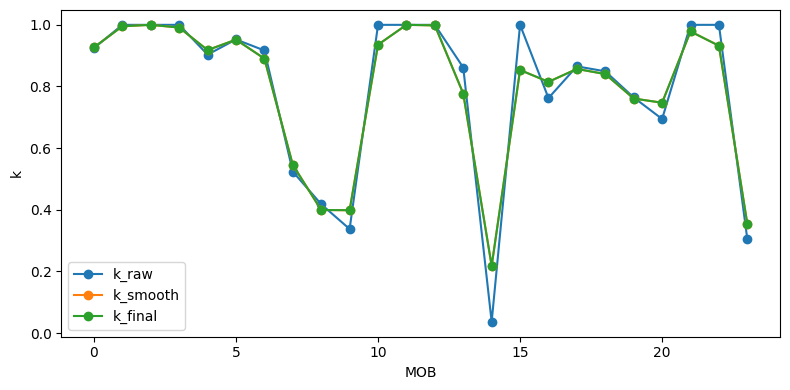

C:\Users\MAFC4709\Python_work\RR_model_1911_Projection\src\rollrate\calibration_kmob.py:847: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,mob,mae_adj,mae_markov
0,1,0.000355,0.000348
1,2,0.001963,0.001966
2,3,0.003223,0.003223
3,4,0.004487,0.004496
4,5,0.003424,0.003442
5,6,0.003180,0.003162
6,7,0.003364,0.003577
7,8,0.008732,0.006860
8,9,0.009930,0.006919
9,10,0.007172,0.004599


In [22]:
# Diagnostics
if k_raw_by_mob:
    plot_k_curves(k_raw_by_mob, k_smooth_by_mob, k_final_by_mob)

err_by_mob = backtest_error_by_mob(
    actual_results=actual_results_fit,
    matrices_by_mob=matrices_by_mob,
    parent_fallback=parent_fallback,
    states=states,
    s30_states=s30_states,
    k_by_mob=k_final_by_mob,
    include_co=True,
    denom_mode="disb",
    disb_total_by_vintage=disb_total_by_vintage_fit,
    min_disb=1e-10,
    weight_mode="equal",
)

err_by_mob


# 7. Seasonality (option – nếu bạn dùng)

In [23]:
# # 7.1. Lấy actual sau calib (hoặc actual trước calib, tuỳ triết lý)
# df_actual_for_season = df_lifecycle_calib[df_lifecycle_calib["IS_FORECAST"] == 0].copy()

# # 7.2. Build seasonality (theo PRODUCT_TYPE × tháng VINTAGE)
# seasonality = build_seasonality(df_actual_for_season, smooth_window=3)

# # 7.3. Áp seasonality cho lifecycle (calib + forecast)
# df_lifecycle_final = apply_seasonality_to_lifecycle(
#     df_lifecycle_calib, seasonality
# )


In [24]:
# df_lifecycle_final da duoc tao o cac cell truoc


# 8. Sale plan: forecast, k-calib, seasonality

## 8.1. Load sale plan và forecast lifecycle theo MOB

In [25]:
# Sale plan section skipped


## 8.2. Áp k & seasonality cho sale plan

In [26]:
# Sale plan section skipped


# 9. Aggregate lên product / portfolio

## 9.1. Từ cohort nhỏ (Product × Score × Vintage × MOB) → lên Product × Vintage × MOB

In [27]:
# Lifecycle history (calibrated + forecast)
df_prod_hist = aggregate_to_product(df_lifecycle_final)

df_prod_hist


C:\Users\MAFC4709\Python_work\RR_model_1911_Projection\src\rollrate\lifecycle.py:430: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,PRODUCT_TYPE,VINTAGE_DATE,MOB,DEL30_PCT,DEL60_PCT,DEL90_PCT,PRODUCT_DISB
0,TOPUP,2023-01-01,6,0.148871,0.110090,0.080837,76.564356
1,TOPUP,2023-01-01,7,0.169454,0.134127,0.100071,76.564356
2,TOPUP,2023-01-01,8,0.187975,0.151715,0.122739,76.564356
3,TOPUP,2023-01-01,9,0.204388,0.168981,0.140963,76.564356
4,TOPUP,2023-01-01,10,0.222990,0.185027,0.161326,76.564356
...,...,...,...,...,...,...,...
2618,XSELL,2025-12-01,32,0.321956,0.310324,0.301535,281.639634
2619,XSELL,2025-12-01,33,0.328694,0.317523,0.309085,281.639634
2620,XSELL,2025-12-01,34,0.335165,0.324435,0.316334,281.639634
2621,XSELL,2025-12-01,35,0.341380,0.331074,0.323295,281.639634


## 9.2. Gộp nhiều product thành portfolio

In [28]:
portfolio_filter = ["CDLPIL", "SALPIL", "SPLPIL", "TOPUP", "TWLPIL", "XSELL"]

df_portfolio_hist = aggregate_products_to_portfolio(
    df_del_prod=df_prod_hist,
    portfolio_name="TOTAL_PIL",
    product_filter=portfolio_filter,
)


C:\Users\MAFC4709\Python_work\RR_model_1911_Projection\src\rollrate\lifecycle.py:496: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [29]:
df_export = pd.concat([
    df_prod_hist,
    df_portfolio_hist,
], ignore_index=True)


In [30]:
# Lifecycle history (regularized k)
df_prod_hist_reg = aggregate_to_product(df_lifecycle_reg)

df_portfolio_hist_reg = aggregate_products_to_portfolio(
    df_del_prod=df_prod_hist_reg,
    portfolio_name="TOTAL_PIL",
    product_filter=portfolio_filter,
)

df_export_reg = pd.concat(
    [df_prod_hist_reg, df_portfolio_hist_reg],
    ignore_index=True,
)


C:\Users\MAFC4709\Python_work\RR_model_1911_Projection\src\rollrate\lifecycle.py:430: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
C:\Users\MAFC4709\Python_work\RR_model_1911_Projection\src\rollrate\lifecycle.py:496: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [31]:
actual_info_prod = (
    df_raw.groupby(["PRODUCT_TYPE", CFG["orig_date"]])["MOB"]
    .max()
    .to_dict()
)

actual_info_all = extend_actual_info_with_portfolio(
    actual_info_prod,
    portfolio_name="TOTAL_PIL",
)

try:
    export_lifecycle_all_products_one_file(
        df_del_prod=df_export,
        actual_info=actual_info_all,
        filename="lifecycle_calibrated_ETB.xlsx",
    )
except PermissionError as e:
    print("Skip export (file locked):", e)
try:
    export_lifecycle_all_products_one_file(
        df_del_prod=df_export_reg,
        actual_info=actual_info_all,
        filename="lifecycle_calibrated_reg_ETB.xlsx",
    )
except PermissionError as e:
    print("Skip export (file locked):", e)


✔ Export lifecycle multi-product thành công → lifecycle_calibrated_ETB.xlsx
✔ Export lifecycle multi-product thành công → lifecycle_calibrated_reg_ETB.xlsx


# 10. Export Excel 